In [0]:
import shutil
import os 
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [0]:
url = "https://storage.googleapis.com/test_bucket_1st/group_project/comp_measure.csv/part-00000-e8efaac3-7299-4aae-a8f5-a606474e2aac-c000.csv"

In [0]:
colab_root = "/content/" 
measure_file = os.path.join(colab_root, "measure.csv")
download_if_missing(url,
                    measure_file,
                    extract=False)

4028923904/4028917448 [==============================] - 40s 0us/step


'/content/measure.csv'

In [0]:
import pandas as pd
measure = pd.read_csv("/content/measure.csv")
measure.head()

,person_id,visit_occurrence_id,year_of_birth,gender_source_value,ethnicity_concept_id,person_source_value,month_of_birth,day_of_birth,ethnicity_source_value,location_id,race_concept_id,gender_concept_id,birth_datetime,race_source_value,death_date,death_datetime,death_type_concept_id,cause_source_concept_id,provider_id,visit_start_date,care_site_id,visit_source_value,visit_end_date,visit_start_datetime,visit_concept_id,visit_type_concept_id,visit_end_datetime,measurement_id,measurement_datetime,measurement_date,value_as_number,value_as_concept_id,measurement_concept_id,measurement_source_concept_id,unit_concept_id,measurement_source_value
0,5,4213630.0,1935,1,38003564,000308435E3E5B76,9,1,1,8,8557.0,8507,1935-09-01T00:00:00.000Z,1,NaN,NaN,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,5.421323e+14,2009-01-09T00:00:00.000Z,2009-01-09T00:00:00.000Z,9202.0,44818517.0,2009-01-09T00:00:00.000Z,2659876.0,2012-07-03T15:42:00.000Z,2010-04-02T00:00:00.000Z,151.0,0.0,2212294.0,2212294.0,9514.0,82565
1,5,4213630.0,1935,1,38003564,000308435E3E5B76,9,1,1,8,8557.0,8507,1935-09-01T00:00:00.000Z,1,NaN,NaN,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,5.421323e+14,2009-01-09T00:00:00.000Z,2009-01-09T00:00:00.000Z,9202.0,44818517.0,2009-01-09T00:00:00.000Z,790690.0,2016-02-23T00:00:00.000Z,2008-12-23T00:00:00.000Z,224.0,0.0,2212290.0,2212290.0,4118323.0,82550
2,5,4213630.0,1935,1,38003564,000308435E3E5B76,9,1,1,8,8557.0,8507,1935-09-01T00:00:00.000Z,1,NaN,NaN,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,5.421323e+14,2009-01-09T00:00:00.000Z,2009-01-09T00:00:00.000Z,9202.0,44818517.0,2009-01-09T00:00:00.000Z,1109419.0,2012-11-13T00:00:00.000Z,2008-12-15T00:00:00.000Z,232.0,0.0,438857.0,44826972.0,8753.0,78191
3,5,4213630.0,1935,1,38003564,000308435E3E5B76,9,1,1,8,8557.0,8507,1935-09-01T00:00:00.000Z,1,NaN,NaN,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,5.421323e+14,2009-01-09T00:00:00.000Z,2009-01-09T00:00:00.000Z,9202.0,44818517.0,2009-01-09T00:00:00.000Z,2261247.0,2013-03-17T00:00:00.000Z,2009-12-05T00:00:00.000Z,223.0,0.0,4034850.0,44835527.0,8862.0,V7260
4,5,4213630.0,1935,1,38003564,000308435E3E5B76,9,1,1,8,8557.0,8507,1935-09-01T00:00:00.000Z,1,NaN,NaN,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,5.421323e+14,2009-01-09T00:00:00.000Z,2009-01-09T00:00:00.000Z,9202.0,44818517.0,2009-01-09T00:00:00.000Z,3587049.0,2012-07-03T11:45:00.000Z,2008-03-21T00:00:00.000Z,263.0,0.0,2212731.0,2212731.0,4118323.0,85610


In [0]:
col_names = ['person_id', 'visit_occurrence_id', 'year_of_birth', 'gender_concept_id', 'ethnicity_concept_id', 'race_concept_id', 'death_date',
             'death_type_concept_id', 'provider_id', 'visit_start_date', 'care_site_id', 'visit_concept_id', 'visit_type_concept_id', 'measurement_id', 
             'value_as_number', 'measurement_concept_id', 'measurement_datetime']

In [0]:
df = measure[col_names]
df.head()

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_date,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime
0,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,2659876.0,151.0,2212294.0,2012-07-03T15:42:00.000Z
1,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,790690.0,224.0,2212290.0,2016-02-23T00:00:00.000Z
2,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,1109419.0,232.0,438857.0,2012-11-13T00:00:00.000Z
3,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,2261247.0,223.0,4034850.0,2013-03-17T00:00:00.000Z
4,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,3587049.0,263.0,2212731.0,2012-07-03T11:45:00.000Z


In [0]:
df.loc[pd.isnull(df['death_date']) , 'death'] = 0
df.loc[pd.isnull(df['death_date'])==False , 'death'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
df.head()

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_date,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime,death
0,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,2659876.0,151.0,2212294.0,2012-07-03T15:42:00.000Z,0.0
1,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,790690.0,224.0,2212290.0,2016-02-23T00:00:00.000Z,0.0
2,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,1109419.0,232.0,438857.0,2012-11-13T00:00:00.000Z,0.0
3,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,2261247.0,223.0,4034850.0,2013-03-17T00:00:00.000Z,0.0
4,5,4213630.0,1935,8507,38003564,8557.0,NaN,NaN,68338.0,2009-01-09T00:00:00.000Z,2870.0,9202.0,44818517.0,3587049.0,263.0,2212731.0,2012-07-03T11:45:00.000Z,0.0


In [0]:
df[df['death'] == 1]

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_date,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime,death
1358,3674,123580.0,1934,8507,38003564,8516.0,2010-06-28T00:00:00.000Z,38003565.0,81524.0,2009-08-30T00:00:00.000Z,42665.0,0.0,44818517.0,NaN,NaN,NaN,NaN,1.0
2007,7820,2210859.0,1921,8532,38003564,8557.0,2010-07-24T00:00:00.000Z,38003565.0,14408.0,2008-09-20T00:00:00.000Z,393.0,0.0,44818517.0,2090228.0,170.0,2212253.0,2012-09-25T14:59:00.000Z,1.0
2008,7820,2210859.0,1921,8532,38003564,8557.0,2010-07-24T00:00:00.000Z,38003565.0,14408.0,2008-09-20T00:00:00.000Z,393.0,0.0,44818517.0,2104520.0,111.0,0.0,2012-03-25T00:00:00.000Z,1.0
2009,7820,2210859.0,1921,8532,38003564,8557.0,2010-07-24T00:00:00.000Z,38003565.0,14408.0,2008-09-20T00:00:00.000Z,393.0,0.0,44818517.0,81867.0,128.0,2212598.0,2013-06-03T15:01:00.000Z,1.0
2010,7820,2210859.0,1921,8532,38003564,8557.0,2010-07-24T00:00:00.000Z,38003565.0,14408.0,2008-09-20T00:00:00.000Z,393.0,0.0,44818517.0,634088.0,176.0,2212648.0,2012-02-17T20:15:00.000Z,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11511658,148293,4093198.0,1915,8532,38003564,8552.0,2010-05-09T00:00:00.000Z,38003565.0,36525.0,2008-11-12T00:00:00.000Z,21413.0,0.0,44818517.0,2664577.0,8.0,2212090.0,2012-12-21T00:00:00.000Z,1.0
11511659,148293,4093198.0,1915,8532,38003564,8552.0,2010-05-09T00:00:00.000Z,38003565.0,36525.0,2008-11-12T00:00:00.000Z,21413.0,0.0,44818517.0,2796171.0,173.0,2212345.0,2013-12-10T12:45:00.000Z,1.0
11511660,148293,4093198.0,1915,8532,38003564,8552.0,2010-05-09T00:00:00.000Z,38003565.0,36525.0,2008-11-12T00:00:00.000Z,21413.0,0.0,44818517.0,3157500.0,84.0,2212238.0,2016-05-02T00:00:00.000Z,1.0
11511661,148293,4093198.0,1915,8532,38003564,8552.0,2010-05-09T00:00:00.000Z,38003565.0,36525.0,2008-11-12T00:00:00.000Z,21413.0,0.0,44818517.0,836566.0,206.0,2212648.0,2013-02-10T01:56:00.000Z,1.0


In [0]:
df.drop('death_date', axis=1, inplace=True)
df.dtypes

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


person_id                   int64
visit_occurrence_id       float64
year_of_birth               int64
gender_concept_id           int64
ethnicity_concept_id        int64
race_concept_id           float64
death_type_concept_id     float64
provider_id               float64
visit_start_date           object
care_site_id              float64
visit_concept_id          float64
visit_type_concept_id     float64
measurement_id            float64
value_as_number           float64
measurement_concept_id    float64
measurement_datetime       object
death                     float64
dtype: object

In [0]:
category = ['person_id', 'visit_occurrence_id', 'gender_concept_id', 'ethnicity_concept_id', 'race_concept_id', 'provider_id', 
            'care_site_id', 'visit_concept_id', 'death_type_concept_id',
            'visit_type_concept_id', 'measurement_id', 'measurement_concept_id']
for i in category:
  df[i] = df[i].astype('str')
df['death'] = df['death'].astype(int)
df['measurement_datetime'] = pd.to_datetime(df['measurement_datetime'])
df['visit_start_date'] = pd.to_datetime(df['visit_start_date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [0]:
df.dtypes
#df.head()

person_id                              object
visit_occurrence_id                    object
year_of_birth                           int64
gender_concept_id                      object
ethnicity_concept_id                   object
race_concept_id                        object
death_type_concept_id                  object
provider_id                            object
visit_start_date          datetime64[ns, UTC]
care_site_id                           object
visit_concept_id                       object
visit_type_concept_id                  object
measurement_id                         object
value_as_number                       float64
measurement_concept_id                 object
measurement_datetime      datetime64[ns, UTC]
death                                   int64
dtype: object

In [0]:
df.groupby('death').mean()

,year_of_birth,value_as_number
death,,
0,1936.534012,65462.561870
1,1937.039264,69228.504855


### Two ways to retrieve most recent measurements (by measure time/ by visit time)

In [0]:
# remove value_as_number with null
df1 = df.dropna(axis=0, subset=['value_as_number'], inplace=False)

In [0]:
df1 = df1.sort_values('measurement_datetime').groupby(['person_id', 'measurement_concept_id']).tail(1).reset_index(drop = True)

In [0]:
#most_recent_visit = df.sort_values('visit_start_date').groupby(['person_id']).tail(1).reset_index(drop = True)[visit_occurrence_id]

In [0]:
df1.head()

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime,death
0,126961,1777960.0,1919,8532,38003564,nan,nan,87689.0,2008-03-20 00:00:00+00:00,13487.0,0.0,44818517.0,2239330.0,213.0,2212599.0,2010-03-13 13:06:00+00:00,0
1,68908,3036315.0,1940,8532,38003564,8657.0,nan,8140.0,2009-02-03 00:00:00+00:00,1278.0,9202.0,44818517.0,1644874.0,242.0,2212523.0,2010-03-13 13:06:00+00:00,0
2,127973,2602685.0,1931,8532,38003564,nan,nan,42427.0,2008-04-04 00:00:00+00:00,7061.0,0.0,44818517.0,2239330.0,213.0,2212599.0,2010-03-13 13:06:00+00:00,0
3,29864,2164686.0,1927,8532,38003564,8657.0,nan,328818.0,2009-03-03 00:00:00+00:00,35227.0,0.0,44818517.0,1374065.0,282.0,2212980.0,2010-03-13 13:06:00+00:00,0
4,125679,3475943.0,1947,8507,38003564,nan,nan,2161.0,2010-05-17 00:00:00+00:00,1403.0,0.0,44818517.0,1130624.0,195.0,2212167.0,2010-03-13 13:06:00+00:00,0


In [0]:
print("in total", df1['measurement_concept_id'].nunique(), "types of measurements")

in total 1018 types of measurements


In [0]:
df1.groupby(['measurement_concept_id'])['measurement_id'].count().nlargest(50)

measurement_concept_id
2212648.0     57966
2212093.0     54805
2212731.0     52664
2212095.0     50112
2212593.0     44369
2212090.0     44084
2313816.0     43393
2212392.0     40728
40482801.0    40203
2212166.0     34822
2313814.0     34002
2313815.0     30317
2212996.0     29269
2212649.0     29118
2212168.0     27058
2212290.0     26990
2212421.0     26178
2212294.0     26077
2212099.0     26073
2212542.0     24863
320536.0      24848
2212591.0     24794
2212238.0     24413
438557.0      24368
2212333.0     23819
4245252.0     23545
2212598.0     23271
2212453.0     23095
0.0           22801
2212422.0     22706
2212359.0     22616
2212165.0     22592
2212300.0     22534
2212605.0     22521
2212167.0     22453
2212295.0     22424
2212742.0     22423
2212611.0     22300
2212367.0     22292
2212523.0     22234
2212597.0     21574
2212615.0     20996
2213031.0     20823
2212507.0     20196
435928.0      20071
2212998.0     19708
2212188.0     18816
2212470.0     18688
2212428.0     184

In [0]:
# drop measurement_concept_id with nan
df2 = df1[df1.measurement_concept_id != 'nan']

In [0]:
df2.groupby(['measurement_concept_id'])['measurement_id'].count().nlargest(20)

measurement_concept_id
2212648.0     57966
2212093.0     54805
2212731.0     52664
2212095.0     50112
2212593.0     44369
2212090.0     44084
2313816.0     43393
2212392.0     40728
40482801.0    40203
2212166.0     34822
2313814.0     34002
2313815.0     30317
2212996.0     29269
2212649.0     29118
2212168.0     27058
2212290.0     26990
2212421.0     26178
2212294.0     26077
2212099.0     26073
2212542.0     24863
Name: measurement_id, dtype: int64

In [0]:
measures = ['2212648.0', '2212093.0', '2212731.0', '2212095.0', '2212593.0', '2212090.0', '2313816.0', '2212392.0', '40482801.0', '2212166.0', '2313814.0', '2313815.0',
            '2212996.0', '2212649.0', '2212168.0', '2212290.0', '2212421.0', '2212099.0', '2212294.0', '2212542.0',
            '320536.0', '2212591.0', '2212238.0', '438557.0', '2212333.0', '4245252.0', '2212598.0', '2212453.0',
            '2212422.0', '2212359.0', '2212165.0', '2212300.0', '2212605.0', '2212167.0', '2212295.0', '2212742.0',
            '2212611.0', '2212367.0', '2212523.0', '2212597.0', '2212615.0', '2213031.0', '2212507.0', '435928.0',
            '2212998.0', '2212188.0', '2212470.0', '2212428.0', '2212589.0']
df3 = df2[df2['measurement_concept_id'].isin(measures)].reset_index(drop = True)

In [0]:
df3['measurement_concept_id'].nunique()

49

In [0]:
df3.dtypes

person_id                              object
visit_occurrence_id                    object
year_of_birth                           int64
gender_concept_id                      object
ethnicity_concept_id                   object
race_concept_id                        object
death_type_concept_id                  object
provider_id                            object
visit_start_date          datetime64[ns, UTC]
care_site_id                           object
visit_concept_id                       object
visit_type_concept_id                  object
measurement_id                         object
value_as_number                       float64
measurement_concept_id                 object
measurement_datetime      datetime64[ns, UTC]
death                                   int64
dtype: object

In [0]:
df3.head()

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime,death
0,64287,5501933.0,1942,8532,38003564,8527.0,nan,216723.0,2008-08-06 00:00:00+00:00,97114.0,0.0,44818517.0,1079175.0,29.0,2212290.0,2010-03-13 13:06:00+00:00,0
1,126153,2766669.0,1931,8532,38003564,8552.0,nan,40145.0,2009-01-27 00:00:00+00:00,23309.0,0.0,44818517.0,3093354.0,309.0,2212542.0,2010-03-13 13:06:00+00:00,0
2,4670,3859650.0,1942,8532,38003564,8552.0,nan,63618.0,2009-07-19 00:00:00+00:00,2273.0,9202.0,44818517.0,3092591.0,2.0,2212093.0,2010-03-13 13:06:00+00:00,0
3,25995,368128.0,1921,8532,38003564,8516.0,nan,140622.0,2008-09-27 00:00:00+00:00,4336.0,0.0,44818517.0,34606.0,296.0,2313814.0,2010-03-13 13:06:00+00:00,0
4,96829,911396.0,1934,8532,38003564,8657.0,nan,6112.0,2008-09-16 00:00:00+00:00,3831.0,0.0,44818517.0,1267637.0,111.0,2212648.0,2010-03-13 13:06:00+00:00,0


In [0]:
df3.replace('nan', 'Unknown', inplace=True)

In [0]:
df3.head()

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime,death
0,64287,5501933.0,1942,8532,38003564,8527.0,Unknown,216723.0,2008-08-06 00:00:00+00:00,97114.0,0.0,44818517.0,1079175.0,29.0,2212290.0,2010-03-13 13:06:00+00:00,0
1,126153,2766669.0,1931,8532,38003564,8552.0,Unknown,40145.0,2009-01-27 00:00:00+00:00,23309.0,0.0,44818517.0,3093354.0,309.0,2212542.0,2010-03-13 13:06:00+00:00,0
2,4670,3859650.0,1942,8532,38003564,8552.0,Unknown,63618.0,2009-07-19 00:00:00+00:00,2273.0,9202.0,44818517.0,3092591.0,2.0,2212093.0,2010-03-13 13:06:00+00:00,0
3,25995,368128.0,1921,8532,38003564,8516.0,Unknown,140622.0,2008-09-27 00:00:00+00:00,4336.0,0.0,44818517.0,34606.0,296.0,2313814.0,2010-03-13 13:06:00+00:00,0
4,96829,911396.0,1934,8532,38003564,8657.0,Unknown,6112.0,2008-09-16 00:00:00+00:00,3831.0,0.0,44818517.0,1267637.0,111.0,2212648.0,2010-03-13 13:06:00+00:00,0


In [0]:
df3[df3.value_as_number.isnull()]

,person_id,visit_occurrence_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,provider_id,visit_start_date,care_site_id,visit_concept_id,visit_type_concept_id,measurement_id,value_as_number,measurement_concept_id,measurement_datetime,death


In [0]:
df4 = df3.drop(['measurement_id', 'visit_occurrence_id', 'provider_id', 'visit_start_date', 
          'measurement_datetime', 'care_site_id', 'visit_concept_id', 'visit_type_concept_id'], axis=1)

In [0]:
df4.drop_duplicates(inplace=True)

In [0]:
df4[df4.value_as_number.isnull()]

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,value_as_number,measurement_concept_id,death


In [0]:
abt = pd.pivot_table(df4, index=['person_id', 'year_of_birth', 'gender_concept_id', 'ethnicity_concept_id', 'race_concept_id', 
                       'death_type_concept_id', 'death'], columns='measurement_concept_id', values = 'value_as_number')

In [0]:
abt.to_csv('/content/abt.csv', index=True)

In [0]:
print(abt.describe())
print("in total", len(abt), "rows")
abt.isna().sum()

measurement_concept_id     2212090.0     2212093.0  ...     2313816.0    40482801.0
count                   4.408400e+04  5.480500e+04  ...  4.339300e+04  4.020300e+04
mean                    5.912809e+04  6.364893e+04  ...  6.790360e+04  6.830467e+04
std                     7.657025e+05  7.943166e+05  ...  8.203251e+05  8.227347e+05
min                     0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00
25%                     7.400000e+01  7.700000e+01  ...  7.600000e+01  7.600000e+01
50%                     1.510000e+02  1.530000e+02  ...  1.520000e+02  1.520000e+02
75%                     2.280000e+02  2.280000e+02  ...  2.290000e+02  2.290000e+02
max                     1.000000e+07  1.000000e+07  ...  1.000000e+07  1.000000e+07

[8 rows x 20 columns]
in total 80383 rows


measurement_concept_id
2212090.0     36299
2212093.0     25578
2212095.0     30271
2212099.0     54310
2212166.0     45561
2212168.0     53325
2212290.0     53393
2212294.0     54306
2212392.0     39655
2212421.0     54205
2212542.0     55520
2212593.0     36014
2212648.0     22417
2212649.0     51265
2212731.0     27719
2212996.0     51114
2313814.0     46381
2313815.0     50066
2313816.0     36990
40482801.0    40180
dtype: int64

In [0]:
abt.head()

,,,,,,measurement_concept_id,2212090.0,2212093.0,2212095.0,2212099.0,2212166.0,2212168.0,2212290.0,2212294.0,2212392.0,2212421.0,2212542.0,2212593.0,2212648.0,2212649.0,2212731.0,2212996.0,2313814.0,2313815.0,2313816.0,40482801.0
person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,,,,,,,,,,,,,,,,,,,,
0,1923,8507,38003564,8552.0,Unknown,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN
10,1936,8532,38003564,8552.0,Unknown,0,266.0,206.0,266.0,83.0,NaN,NaN,12.0,NaN,10000000.0,223.0,3.0,272.0,155.0,134.0,26.0,44.0,237.0,NaN,173.0,20.0
100,1943,8532,38003564,8552.0,Unknown,0,301.0,NaN,210.0,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
100001,1947,8507,38003564,8657.0,Unknown,0,NaN,171.0,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244.0,299.0,NaN,290.0,NaN,9.0,135.0,134.0,NaN
100003,1936,8532,38003564,8527.0,Unknown,0,NaN,NaN,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Join all the tables together

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls /content/drive/My\ Drive/big_data/group_project

condition1.csv	drug.csv	    measure_abt.csv
df_final2.csv	finalcondition.csv  observation1.csv
df_final.csv	finalprocedure.csv  procedure1.csv


In [0]:
import pandas as pd

In [0]:
condition = pd.read_csv("/content/drive/My Drive/big_data/group_project/finalcondition.csv")
drug = pd.read_csv("/content/drive/My Drive/big_data/group_project/drug.csv")
measure = pd.read_csv("/content/drive/My Drive/big_data/group_project/measure_abt.csv")
obs = pd.read_csv("/content/drive/My Drive/big_data/group_project/observation1.csv")
procedure = pd.read_csv("/content/drive/My Drive/big_data/group_project/finalprocedure.csv")

In [0]:
condition.head()
#condition.drop(condition.columns[0], axis=1, inplace=True)

,person_id,condition_num,visit_concept_id,condition_type_concept_id,death
0,0,1,9202.0,38000230.0,0
1,5,1,9202.0,38000230.0,0
2,6,70,0.0,38000230.0,0
3,7,2,0.0,38000230.0,0
4,8,55,0.0,38000230.0,0


In [0]:
condition.drop(['visit_occurrence_id', 'year_of_birth', 'ethnicity_concept_id',
                'month_of_birth', 'day_of_birth', 'race_concept_id', 'gender_concept_id',
                'visit_concept_id', 'death', 'visit_datetime_difference'], axis=1, inplace=True)

KeyError: ignored

In [0]:
condition.drop(['visit_concept_id', 'death'], axis=1, inplace=True)
condition.head()

,person_id,condition_num,condition_type_concept_id
0,0,1,38000230.0
1,5,1,38000230.0
2,6,70,38000230.0
3,7,2,38000230.0
4,8,55,38000230.0


In [0]:
drug.drop(drug.columns[0], axis=1, inplace=True)
drug.head()

,person_id,drug_num
0,0,1.0
1,5,1.0
2,6,1.0
3,7,1.0
4,8,1.0


In [0]:
measure2 = pd.read_csv('/content/abt.csv')
len(measure2[measure2['death'] == 1])

928

In [0]:
measure.head()

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,2212090.0,2212093.0,2212095.0,2212099.0,2212166.0,2212168.0,2212290.0,2212294.0,2212392.0,2212421.0,2212542.0,2212593.0,2212648.0,2212649.0,2212731.0,2212996.0,2313814.0,2313815.0,2313816.0,40482801.0
0,0,1923,8507,38003564,8552.0,Unknown,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN
1,10,1936,8532,38003564,8552.0,Unknown,0,266.0,206.0,266.0,83.0,NaN,NaN,12.0,NaN,10000000.0,223.0,3.0,272.0,155.0,134.0,26.0,44.0,237.0,NaN,173.0,20.0
2,100,1943,8532,38003564,8552.0,Unknown,0,301.0,NaN,210.0,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,100001,1947,8507,38003564,8657.0,Unknown,0,NaN,171.0,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244.0,299.0,NaN,290.0,NaN,9.0,135.0,134.0,NaN
4,100003,1936,8532,38003564,8527.0,Unknown,0,NaN,NaN,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [0]:
measure.fillna('none', inplace=True)
measure.head()

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,2212090.0,2212093.0,2212095.0,2212099.0,2212166.0,2212168.0,2212290.0,2212294.0,2212392.0,2212421.0,2212542.0,2212593.0,2212648.0,2212649.0,2212731.0,2212996.0,2313814.0,2313815.0,2313816.0,40482801.0
0,0,1923,8507,38003564,8552.0,Unknown,0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,220,none,none,none,none,none
1,10,1936,8532,38003564,8552.0,Unknown,0,266,206,266,83,none,none,12,none,1e+07,223,3,272,155,134,26,44,237,none,173,20
2,100,1943,8532,38003564,8552.0,Unknown,0,301,none,210,none,148,none,none,none,none,none,none,none,none,none,none,none,none,none,21,none
3,100001,1947,8507,38003564,8657.0,Unknown,0,none,171,244,none,none,none,none,none,none,none,none,244,299,none,290,none,9,135,134,none
4,100003,1936,8532,38003564,8527.0,Unknown,0,none,none,196,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,0


In [0]:
obs.drop(obs.columns[1], axis=1, inplace=True)
obs.head()

,person_id,0.0,439405.0,440922.0,440927.0,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,4046550.0,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,4167217.0,4186037.0,4214956.0,40479553.0
0,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
obs.fillna(0, inplace=True)

In [0]:
obs.head()

,person_id,0.0,439405.0,440922.0,440927.0,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,4046550.0,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,4167217.0,4186037.0,4214956.0,40479553.0
0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#procedure.drop(procedure.columns[0], axis=1, inplace=True)
procedure.head()

,person_id,procedure_num
0,0,1.0
1,5,17.0
2,6,1.0
3,7,1.0
4,8,10.0


In [0]:
procedure.drop(['visit_occurrence_id', 'year_of_birth', 'ethnicity_concept_id', 
                'visit_concept_id', 'death'], axis=1, inplace = True)
procedure.head()

,person_id,procedure1,procedure2,procedure3,procedure4,procedure5,procedure6,procedure7,procedure8,procedure9,procedure10,month_of_birth,day_of_birth,race_concept_id,gender_concept_id
0,0,2005317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,8552.0,8507
1,5,2101925.0,2514424.0,2211379.0,2314268.0,2005474.0,2003402.0,2414396.0,2314285.0,2003746.0,2002291.0,9,1,8557.0,8507
2,6,2002291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,8527.0,8532
3,7,2001200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,8657.0,8532
4,8,2414397.0,2414397.0,2001389.0,2003749.0,2213601.0,2002586.0,2002291.0,2211446.0,2617177.0,2314297.0,2,1,8657.0,8532


In [0]:
procedure.drop(['race_concept_id', 'gender_concept_id'], axis=1, inplace=True)
procedure.head()

,person_id,procedure1,procedure2,procedure3,procedure4,procedure5,procedure6,procedure7,procedure8,procedure9,procedure10,month_of_birth,day_of_birth
0,0,2005317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1
1,5,2101925.0,2514424.0,2211379.0,2314268.0,2005474.0,2003402.0,2414396.0,2314285.0,2003746.0,2002291.0,9,1
2,6,2002291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1
3,7,2001200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
4,8,2414397.0,2414397.0,2001389.0,2003749.0,2213601.0,2002586.0,2002291.0,2211446.0,2617177.0,2314297.0,2,1


In [0]:
# merge all tables
from functools import reduce
df_list = [measure, drug, obs, condition, procedure]
df_final = reduce(lambda left,right: pd.merge(left,right,on='person_id'), df_list)
df_final.head()

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,2212090.0,2212093.0,2212095.0,2212099.0,2212166.0,2212168.0,2212290.0,2212294.0,2212392.0,2212421.0,2212542.0,2212593.0,2212648.0,2212649.0,2212731.0,2212996.0,2313814.0,2313815.0,2313816.0,40482801.0,drug_num,0.0,439405.0,440922.0,440927.0,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,4046550.0,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,4167217.0,4186037.0,4214956.0,40479553.0,condition_num,condition_type_concept_id,procedure_num
0,0,1923,8507,38003564,8552.0,Unknown,0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,220,none,none,none,none,none,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,38000230.0,1.0
1,10,1936,8532,38003564,8552.0,Unknown,0,266,206,266,83,none,none,12,none,1e+07,223,3,272,155,134,26,44,237,none,173,20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,3.0
2,100,1943,8532,38003564,8552.0,Unknown,0,301,none,210,none,148,none,none,none,none,none,none,none,none,none,none,none,none,none,21,none,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,150.0
3,100001,1947,8507,38003564,8657.0,Unknown,0,none,171,244,none,none,none,none,none,none,none,none,244,299,none,290,none,9,135,134,none,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,75,38000230.0,150.0
4,100003,1936,8532,38003564,8527.0,Unknown,0,none,none,196,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,38000230.0,1.0


In [0]:
len(df_final)

80383

In [0]:
df_final.to_csv('/content/df_final.csv', index=False)

In [0]:
len(df_final[df_final['death'] == 1])

915

In [0]:
len(measure[measure['death'] == 1])

915

## Balance data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/My\ Drive/big_data/group_project

condition1.csv	df_final.csv	    finalprocedure.csv	procedure1.csv
df_final2.csv	drug.csv	    measure_abt.csv
df_final3.csv	finalcondition.csv  observation1.csv


In [0]:
import pandas as pd
import numpy as np

In [0]:
#df_abt = pd.read_csv("/content/drive/My Drive/big_data/group_project/df_final2.csv")
df_abt = pd.read_csv("/content/drive/My Drive/big_data/group_project/df_final3.csv")

In [6]:
df_abt.drop(df_abt.columns[0], axis=1, inplace=True)
df_abt.head()

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,basic_metabolic_panel,compreh_metabolic_panel,lipid_panel,hepatic_func_panel,Urinalysis_with_microscopy,Urinalysis_without_microscopy,"Creatine kinase (CK), (CPK); total",Creatinine; blood,Hemoglobin; glycosylated (A1C),Iron,Prostate specific antigen (PSA); total,Thyroid stimulating hormone (TSH),"Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count","Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)",Prothrombin time,"Culture, bacterial; quantitative colony count, urine",2313814.0,"Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report",2313816.0,40482801.0,drug_num,0.0,Walking disability,Diabetic on insulin,High risk drug monitoring status,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,Postoperative care,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,Family history of clinical finding,Aftercare,History of clinical finding in subject,Cardiac pacemaker in situ,condition_num,condition_type_concept_id,procedure_num
0,0,1923,8507,38003564,8552.0,Unknown,0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,220.0,none,none,none,none,none,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,38000230.0,1.0
1,10,1936,8532,38003564,8552.0,Unknown,0,266.0,206.0,266.0,83.0,none,none,12.0,none,10000000.0,223.0,3.0,272.0,155.0,134.0,26.0,44.0,237.0,none,173.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,3.0
2,100,1943,8532,38003564,8552.0,Unknown,0,301.0,none,210.0,none,148.0,none,none,none,none,none,none,none,none,none,none,none,none,none,21.0,none,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,150.0
3,100001,1947,8507,38003564,8657.0,Unknown,0,none,171.0,244.0,none,none,none,none,none,none,none,none,244.0,299.0,none,290.0,none,9.0,135.0,134.0,none,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,75,38000230.0,150.0
4,100003,1936,8532,38003564,8527.0,Unknown,0,none,none,196.0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,38000230.0,1.0


In [0]:
df_abt[df_abt['death'] == 1] # in total 915 people

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,basic_metabolic_panel,compreh_metabolic_panel,lipid_panel,hepatic_func_panel,Urinalysis_with_microscopy,Urinalysis_without_microscopy,"Creatine kinase (CK), (CPK); total",Creatinine; blood,Hemoglobin; glycosylated (A1C),Iron,Prostate specific antigen (PSA); total,Thyroid stimulating hormone (TSH),"Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count","Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)",Prothrombin time,"Culture, bacterial; quantitative colony count, urine",2313814.0,"Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report",2313816.0,40482801.0,drug_num,0.0,Walking disability,Diabetic on insulin,High risk drug monitoring status,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,Postoperative care,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,Family history of clinical finding,Aftercare,History of clinical finding in subject,Cardiac pacemaker in situ,condition1,condition2,condition3,condtion4,condition5,condition6,condition7,condition8,condition9,condition10,procedure1,procedure2,procedure3,procedure4,procedure5,procedure6,procedure7,procedure8,procedure9,procedure10,month_of_birth,day_of_birth
29,100040,1932,8532,38003564,Unknown,38003565.0,1,none,none,none,none,none,none,none,none,none,none,none,none,157.0,194.0,208.0,none,none,none,none,none,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4116950.0,378087.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1
92,100137,1956,8532,38003564,8527.0,38003565.0,1,none,none,135.0,none,none,none,none,none,none,none,none,28.0,none,none,none,297.0,none,none,none,none,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2211327.0,2108115.0,4141759.0,2314331.0,2001200.0,2514409.0,2002291.0,2108115.0,2313991.0,2514414.0,1,1
263,100436,1922,8507,38003564,8552.0,38003565.0,1,195.0,275.0,254.0,none,101.0,133.0,39.0,73.0,58.0,312.0,35.0,68.0,141.0,155.0,61.0,270.0,274.0,75.0,204.0,132.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007278.0,4141759.0,2414397.0,0.0,2004709.0,2314262.0,2002291.0,2414398.0,2108115.0,NaN,9,1
282,100460,1950,8507,38003564,8516.0,38003565.0,1,19.0,24.0,3.0,none,115.0,54.0,none,none,23.0,38.0,none,38.0,299.0,179.0,277.0,118.0,35.0,301.0,90.0,157.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,135768.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,1
368,100632,1930,8532,38003564,8516.0,38003565.0,1,none,103.0,295.0,none,none,none,237.0,none,none,174.0,none,15.0,129.0,none,166.0,none,40.0,267.0,none,186.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197028.0,201826.0,0.0,440649.0,NaN,NaN,NaN,NaN,NaN,NaN,2002291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79741,98870,1923,8507,38003564,8516.0,38003565.0,1,47.0,106.0,119.0,199.0,220.0,none,14.0,none,258.0,none,none,190.0,72.0,182.0,122.0,none,98.0,281.0,168.0,222.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2314269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1
79841,99053,1933,8532,38003564,8557.0,38003565.0,1,232.0,71.0,none,none,none,none,none,none,4.0,none,none,148.0,none,none,none,none,none,none,none,none,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Oversample

In [7]:
# impute first and then split and then oversampling
df_abt.replace('none', np.nan, inplace = True)
df_abt.drop('death_type_concept_id', axis=1, inplace=True)
numeric = ['year_of_birth', 'basic_metabolic_panel', 'compreh_metabolic_panel', 'lipid_panel', 'hepatic_func_panel', 'Urinalysis_with_microscopy', 
           'Urinalysis_without_microscopy', 'Creatine kinase (CK), (CPK); total', 'Creatinine; blood', 'Hemoglobin; glycosylated (A1C)',
           'Iron', 'Prostate specific antigen (PSA); total', 'Thyroid stimulating hormone (TSH)', 'Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count',
           'Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)', 'Prothrombin time', 'Culture, bacterial; quantitative colony count, urine',
           '2313814.0', 'Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report', '2313816.0', 
           '40482801.0', 'drug_num', 'condition_num', 'procedure_num']

for i in df_abt.columns:
  if i in numeric:
    df_abt[i] = df_abt[i].astype('float')
  else:
    df_abt[i] = df_abt[i].astype('str')
df_abt.fillna(df_abt.mean(), inplace=True)

category = []
for i in df_abt.loc[:, 'gender_concept_id':].columns:
  if i not in numeric:
    category.append(i)

category.remove('death')
unused_col = ['0.0', '2614666.0', '2614668.0', '2614669.0', '2614670.0', '2720870.0', '4015724.0', '4058431.0', '4059356.0', '4059467.0', '4060089.0',
              '4090651.0']
df_abt.drop(unused_col, axis=1, inplace=True)       

dummied = pd.get_dummies(df_abt.loc[:, 'gender_concept_id':], columns = [x for x in category if x not in unused_col], drop_first=True)
abt = pd.concat([df_abt['person_id'], dummied], axis=1)

X = abt.drop(['death', 'person_id'], axis=1, inplace=False)
y = abt['death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_resampled, columns=X_train.columns)
y_train = pd.Series(y_resampled, index=X_train.index)

#X_train = X_resampled
#y_train = y_resampled

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(df_abt.drop('death', axis=1), df_abt['death'])

In [0]:
df_balance = pd.DataFrame(X_resampled, columns=df_abt.drop('death', axis=1).columns)
df_balance['death'] = pd.Series(y_resampled, index=df_balance.index)

In [0]:
print("number of death:", len(df_balance[df_balance['death'] == 1]))

number of death: 79468


In [0]:
print("number of alive:", len(df_balance[df_balance['death'] == 0]))

number of alive: 79468


### Downsample

In [0]:
df_alive = df_abt[df_abt['death'] == 0].sample(1000) 
df_dead = df_abt[df_abt['death'] == 1]
df_balance = df_alive.append(df_dead, ignore_index=True)

In [0]:
print(len(df_balance))
df_balance.head()

1915


,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,death,basic_metabolic_panel,compreh_metabolic_panel,lipid_panel,hepatic_func_panel,Urinalysis_with_microscopy,Urinalysis_without_microscopy,"Creatine kinase (CK), (CPK); total",Creatinine; blood,Hemoglobin; glycosylated (A1C),Iron,Prostate specific antigen (PSA); total,Thyroid stimulating hormone (TSH),"Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count","Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)",Prothrombin time,"Culture, bacterial; quantitative colony count, urine",2313814.0,"Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report",2313816.0,40482801.0,drug_num,0.0,Walking disability,Diabetic on insulin,High risk drug monitoring status,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,Postoperative care,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,Family history of clinical finding,Aftercare,History of clinical finding in subject,Cardiac pacemaker in situ,condition_num,condition_type_concept_id,procedure_num
0,91165,1938,8507,38003564,8557.0,Unknown,0,none,152.0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,38000230.0,19.0
1,113985,1942,8507,38003564,8657.0,Unknown,0,246.0,270.0,239.0,265.0,191.0,84.0,275.0,116.0,181.0,13.0,118.0,248.0,20.0,226.0,139.0,222.0,204.0,265.0,170.0,105.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,1.0
2,147917,1957,8507,38003563,8557.0,Unknown,0,none,82.0,9999999.0,237.0,none,none,none,none,50.0,none,none,none,150.0,none,none,136.0,none,none,none,102.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,38000230.0,1.0
3,47995,1942,8507,38003564,8657.0,Unknown,0,none,6.0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,234.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,1.0
4,81746,1935,8507,38003564,8515.0,Unknown,0,none,149.0,none,none,none,none,none,none,none,none,none,none,146.0,none,none,none,none,none,0.0,none,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,1.0


### Tidy up column types

In [0]:
df_balance.dtypes

person_id                                                                                                              object
year_of_birth                                                                                                          object
gender_concept_id                                                                                                      object
ethnicity_concept_id                                                                                                   object
race_concept_id                                                                                                        object
death_type_concept_id                                                                                                  object
basic_metabolic_panel                                                                                                  object
compreh_metabolic_panel                                                                                               

In [0]:
#df_balance.drop(list(df_balance.filter(regex = 'condition')), axis = 1, inplace = True)

In [0]:
#df_balance.drop('condtion4', axis=1, inplace=True)
df_balance

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,basic_metabolic_panel,compreh_metabolic_panel,lipid_panel,hepatic_func_panel,Urinalysis_with_microscopy,Urinalysis_without_microscopy,"Creatine kinase (CK), (CPK); total",Creatinine; blood,Hemoglobin; glycosylated (A1C),Iron,Prostate specific antigen (PSA); total,Thyroid stimulating hormone (TSH),"Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count","Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)",Prothrombin time,"Culture, bacterial; quantitative colony count, urine",2313814.0,"Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report",2313816.0,40482801.0,drug_num,0.0,Walking disability,Diabetic on insulin,High risk drug monitoring status,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,Postoperative care,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,Family history of clinical finding,Aftercare,History of clinical finding in subject,Cardiac pacemaker in situ,condition_num,condition_type_concept_id,procedure_num,death
0,0,1923,8507,38003564,8552.0,Unknown,none,none,none,none,none,none,none,none,none,none,none,none,none,none,220.0,none,none,none,none,none,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,3.80002e+07,1,0
1,10,1936,8532,38003564,8552.0,Unknown,266.0,206.0,266.0,83.0,none,none,12.0,none,10000000.0,223.0,3.0,272.0,155.0,134.0,26.0,44.0,237.0,none,173.0,20.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.80002e+07,3,0
2,100,1943,8532,38003564,8552.0,Unknown,301.0,none,210.0,none,148.0,none,none,none,none,none,none,none,none,none,none,none,none,none,21.0,none,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.80002e+07,150,0
3,100001,1947,8507,38003564,8657.0,Unknown,none,171.0,244.0,none,none,none,none,none,none,none,none,244.0,299.0,none,290.0,none,9.0,135.0,134.0,none,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,75,3.80002e+07,150,0
4,100003,1936,8532,38003564,8527.0,Unknown,none,none,196.0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,3.80002e+07,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158931,6445,1953,8532,38003564,8515.0,38003565.0,243.0,none,none,none,147.0,none,none,none,none,none,none,34.0,199.0,none,none,none,none,none,none,none,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.80002e+07,20,1
158932,17426,1919,8532,38003564,Unknown,38003565.0,none,93.0,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none,230.0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,3.80002e+07,1,1
158933,29573,1931,8507,38003563,8657.0,38003565.0,none,255.0,202.0,none,none,none,none,none,none,none,none,none,151.0,none,117.0,none,none,none,130.0,none,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.80002e+07,15,1
158934,124667,1943,8532,38003564,8657.0,38003565.0,216.0,281.0,310.0,none,72.0,none,153.0,none,255.0,142.0,none,none,242.0,none,260.0,none,none,194.0,59.0,none,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.80002e+07,4,1


In [0]:
df_balance.replace('none', np.nan, inplace = True)

In [0]:
df_balance.head()

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,death_type_concept_id,basic_metabolic_panel,compreh_metabolic_panel,lipid_panel,hepatic_func_panel,Urinalysis_with_microscopy,Urinalysis_without_microscopy,"Creatine kinase (CK), (CPK); total",Creatinine; blood,Hemoglobin; glycosylated (A1C),Iron,Prostate specific antigen (PSA); total,Thyroid stimulating hormone (TSH),"Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count","Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)",Prothrombin time,"Culture, bacterial; quantitative colony count, urine",2313814.0,"Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report",2313816.0,40482801.0,drug_num,0.0,Walking disability,Diabetic on insulin,High risk drug monitoring status,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,Postoperative care,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,Family history of clinical finding,Aftercare,History of clinical finding in subject,Cardiac pacemaker in situ,condition_num,condition_type_concept_id,procedure_num,death
0,0,1923,8507,38003564,8552.0,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,38000230.0,1.0,0
1,10,1936,8532,38003564,8552.0,Unknown,266.0,206.0,266.0,83.0,NaN,NaN,12.0,NaN,10000000.0,223.0,3.0,272.0,155.0,134.0,26.0,44.0,237.0,NaN,173.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,3.0,0
2,100,1943,8532,38003564,8552.0,Unknown,301.0,NaN,210.0,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,38000230.0,150.0,0
3,100001,1947,8507,38003564,8657.0,Unknown,NaN,171.0,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244.0,299.0,NaN,290.0,NaN,9.0,135.0,134.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,75,38000230.0,150.0,0
4,100003,1936,8532,38003564,8527.0,Unknown,NaN,NaN,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,38000230.0,1.0,0


In [0]:
df_balance.drop('death_type_concept_id', axis=1, inplace=True)

In [0]:
numeric = ['year_of_birth', 'basic_metabolic_panel', 'compreh_metabolic_panel', 'lipid_panel', 'hepatic_func_panel', 'Urinalysis_with_microscopy', 
           'Urinalysis_without_microscopy', 'Creatine kinase (CK), (CPK); total', 'Creatinine; blood', 'Hemoglobin; glycosylated (A1C)',
           'Iron', 'Prostate specific antigen (PSA); total', 'Thyroid stimulating hormone (TSH)', 'Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count',
           'Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)', 'Prothrombin time', 'Culture, bacterial; quantitative colony count, urine',
           '2313814.0', 'Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report', '2313816.0', 
           '40482801.0', 'drug_num', 'condition_num', 'procedure_num']

for i in df_balance.columns:
  if i in numeric:
    df_balance[i] = df_balance[i].astype('float')
  else:
    df_balance[i] = df_balance[i].astype('str')

### Impute using KNN

In [0]:
# impute using KNN
from fancyimpute import KNN
imputed = pd.DataFrame(data=KNN(k=5).fit_transform(df_balance[numeric]), columns=df_balance[numeric].columns)
df_balance = pd.concat([df_balance.select_dtypes(include='object'), imputed], axis=1)

### Impute using mean

In [0]:
# impute with mean
df_balance.fillna(df_balance.mean(), inplace=True)

In [0]:
df_balance.head()

,person_id,year_of_birth,gender_concept_id,ethnicity_concept_id,race_concept_id,basic_metabolic_panel,compreh_metabolic_panel,lipid_panel,hepatic_func_panel,Urinalysis_with_microscopy,Urinalysis_without_microscopy,"Creatine kinase (CK), (CPK); total",Creatinine; blood,Hemoglobin; glycosylated (A1C),Iron,Prostate specific antigen (PSA); total,Thyroid stimulating hormone (TSH),"Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count","Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count)",Prothrombin time,"Culture, bacterial; quantitative colony count, urine",2313814.0,"Electrocardiogram, routine ECG with at least 12 leads; tracing only, without interpretation and report",2313816.0,40482801.0,drug_num,0.0,Walking disability,Diabetic on insulin,High risk drug monitoring status,2614666.0,2614668.0,2614669.0,2614670.0,2720870.0,4015724.0,Postoperative care,4058431.0,4059356.0,4059467.0,4060089.0,4090651.0,Family history of clinical finding,Aftercare,History of clinical finding in subject,Cardiac pacemaker in situ,condition_num,condition_type_concept_id,procedure_num,death
0,0,1923.0,8507,38003564,8552.0,57720.350066,88271.141849,91030.123187,131880.058983,66051.027379,88851.450277,54233.872542,46161.581448,9.567379e+04,64004.834026,70972.188132,69499.789852,63722.801384,64397.8482,220.00000,41740.119135,95142.025722,28683.991033,105292.454738,68300.049067,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,38000230.0,1.0,0
1,10,1936.0,8532,38003564,8552.0,266.000000,206.000000,266.000000,83.000000,66051.027379,88851.450277,12.000000,46161.581448,1.000000e+07,223.000000,3.000000,272.000000,155.000000,134.0000,26.00000,44.000000,237.000000,28683.991033,173.000000,20.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,38000230.0,3.0,0
2,100,1943.0,8532,38003564,8552.0,301.000000,88271.141849,210.000000,131880.058983,148.000000,88851.450277,54233.872542,46161.581448,9.567379e+04,64004.834026,70972.188132,69499.789852,63722.801384,64397.8482,84613.76014,41740.119135,95142.025722,28683.991033,21.000000,68300.049067,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,38000230.0,150.0,0
3,100001,1947.0,8507,38003564,8657.0,57720.350066,171.000000,244.000000,131880.058983,66051.027379,88851.450277,54233.872542,46161.581448,9.567379e+04,64004.834026,70972.188132,244.000000,299.000000,64397.8482,290.00000,41740.119135,9.000000,135.000000,134.000000,68300.049067,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,75.0,38000230.0,150.0,0
4,100003,1936.0,8532,38003564,8527.0,57720.350066,88271.141849,196.000000,131880.058983,66051.027379,88851.450277,54233.872542,46161.581448,9.567379e+04,64004.834026,70972.188132,69499.789852,63722.801384,64397.8482,84613.76014,41740.119135,95142.025722,28683.991033,105292.454738,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,38000230.0,1.0,0


## Modeling

### One-hot encoding for categorical features

In [8]:
category = []
for i in df_balance.loc[:, 'gender_concept_id':].columns:
  if i not in numeric:
    category.append(i)


NameError: ignored

In [0]:
category.remove('death')
category

['gender_concept_id',
 'ethnicity_concept_id',
 'race_concept_id',
 '0.0',
 'Walking disability',
 'Diabetic on insulin',
 'High risk drug monitoring status',
 '2614666.0',
 '2614668.0',
 '2614669.0',
 '2614670.0',
 '2720870.0',
 '4015724.0',
 'Postoperative care',
 '4058431.0',
 '4059356.0',
 '4059467.0',
 '4060089.0',
 '4090651.0',
 'Family history of clinical finding',
 'Aftercare',
 'History of clinical finding in subject',
 'Cardiac pacemaker in situ',
 'condition_type_concept_id']

In [0]:
unused_col = ['0.0', '2614666.0', '2614668.0', '2614669.0', '2614670.0', '2720870.0', '4015724.0', '4058431.0', '4059356.0', '4059467.0', '4060089.0',
              '4090651.0']

In [0]:
df_balance.drop(unused_col, axis=1, inplace=True)

In [0]:
dummied = pd.get_dummies(df_balance.loc[:, 'gender_concept_id':], columns = [x for x in category if x not in unused_col], drop_first=True)

In [0]:
abt = pd.concat([df_balance['person_id'], dummied], axis=1)

In [0]:
X = abt.drop(['death', 'person_id'], axis=1, inplace=False)
y = abt['death']

### Split into train and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Logistic regression

In [16]:
clf = LogisticRegression(random_state=123).fit(X_train, y_train)
predictions = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [11]:
predictions

array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

In [17]:
score = clf.score(X_test, y_test)
print(score)

0.9890027866242038


In [18]:
confusion_matrix(y_test, predictions)

array([[19875,     0],
       [  221,     0]])

### Decision Tree

In [0]:
from sklearn import tree
from sklearn.metrics import accuracy_score
model = tree.DecisionTreeClassifier(random_state=123).fit(X_train, y_train)

In [0]:
y_predict = model.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

array([[19525,   350],
       [  218,     3]])

In [22]:
accuracy_score(y_test, y_predict)

0.9717356687898089


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.5002197 | Std - 0.003324146 | Min - 0.4956679 | Max - 0.5054112


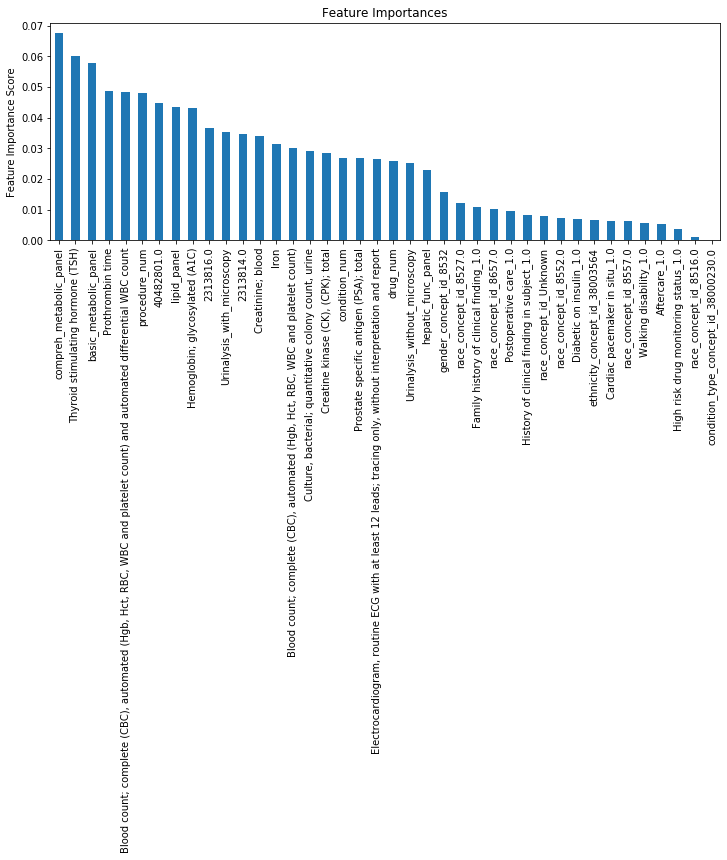

In [39]:
tc = tree.DecisionTreeClassifier(random_state=123)
modelfit(tc, pd.concat([X_train, y_train], axis=1), X_train.columns)

In [29]:
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image 

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.982548 to fit
tcmalloc: large alloc 1641627648 bytes == 0x55daa02a0000 @  0x7f6f288d8001 0x7f6f24b6f1fa 0x7f6f24b6f2ad 0x7f6f25cfa6df 0x7f6f261f1261 0x7f6f2866e468 0x7f6f28670d53 0x55da9bfe4092 0x7f6f28023b97 0x55da9bfe412a



### Support Vector Machine

In [0]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X_train,y_train)
y_prdict = clf.predict(X_test)
accuracy_score(y_test, y_predict)

In [0]:
y_predict

array(['1', '1', '0', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0',
       '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0',
       '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1',
       '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '1', '1',
       '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '1',
       '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '1', '0', '0',
       '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1',
       '0', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '1', '0',
       '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1',
       '1', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0',
       '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1

In [0]:
X.iloc[:, 30]

0       1
1       1
2       1
3       1
4       1
       ..
1910    0
1911    0
1912    0
1913    0
1914    0
Name: death_type_concept_id_Unknown, Length: 1915, dtype: uint8

### Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [0]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #alg = GridSearchCV(alg, parameters, cv=10, n_jobs=-1)
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['death'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain['death'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['death'].values, dtrain_predictions)) 
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['death'], dtrain_predprob)) 
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))) 
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9891
AUC Score (Train): 0.784703
CV Score : Mean - 0.5061349 | Std - 0.01533572 | Min - 0.4842711 | Max - 0.5304716


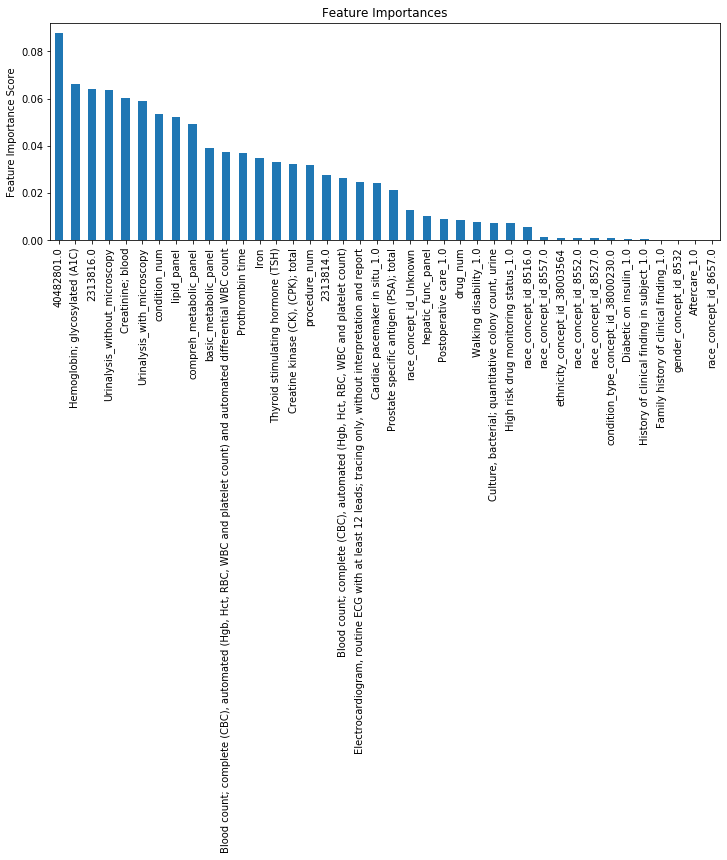

In [25]:
#Choose all predictors except target
gbm0 = GradientBoostingClassifier(random_state=123)
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
y_train = y_train.rename("death")
modelfit(gbm0, pd.concat([X_train, y_train], axis=1), X_train.columns)

In [0]:
y_predict = gbm0.predict(X_test)
y_prob = gbm0.predict_proba(X_test)[:,1]

0.9877089968152867
0.5210834685107715
0.9889885401096163
0.9986918238993711
0.9938164976843159


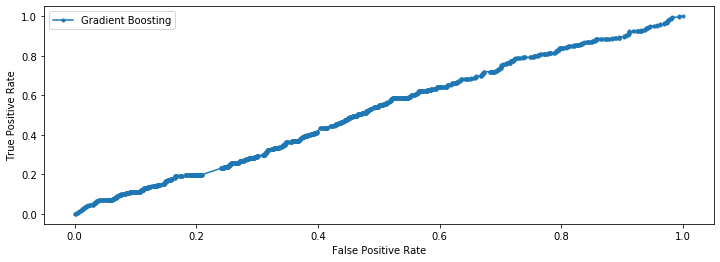

In [41]:
print(accuracy_score(y_test, y_predict))
print(metrics.roc_auc_score(y_test, y_prob))
print(metrics.precision_score(y_test, y_predict, average="binary", pos_label='0'))
print(metrics.recall_score(y_test, y_predict, average="binary", pos_label='0'))
print(metrics.f1_score(y_test, y_predict, average="binary", pos_label='0'))
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob, pos_label='1')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [18]:
confusion_matrix(y_test, y_predict)

array([[12941,  6956],
       [  125,    74]])

### XGboost


Model Report
Accuracy : 0.7428
AUC Score (Train): 0.829740
CV Score : Mean - 0.8195829 | Std - 0.00327759 | Min - 0.8147111 | Max - 0.825033


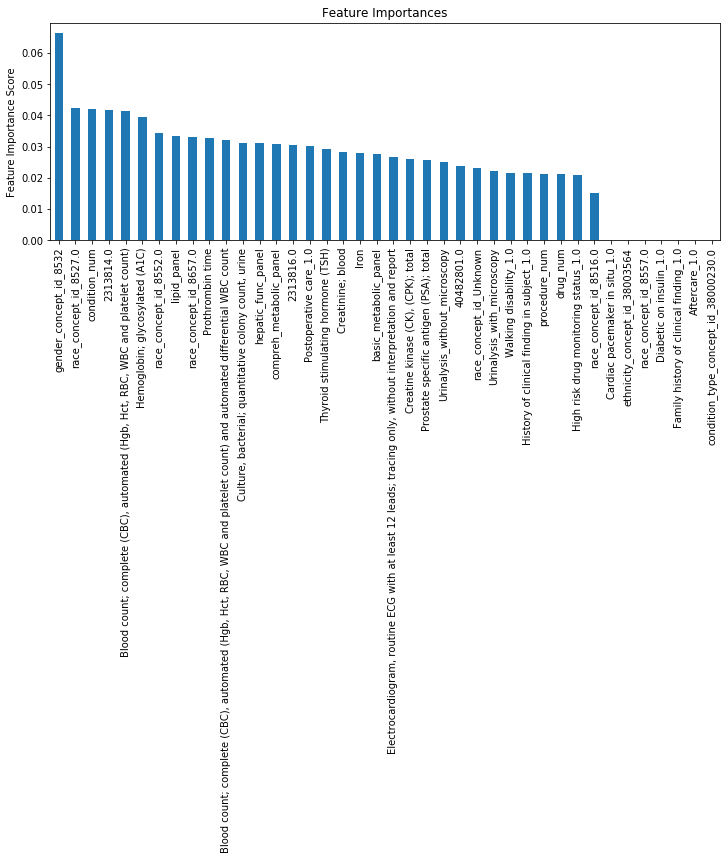

In [19]:
from xgboost import XGBClassifier

model = XGBClassifier()
#model.fit(X_train, y_train)
modelfit(model, pd.concat([X_train, y_train], axis=1), X_train.columns)

In [20]:
y_predict = model.predict(X_test)
accuracy_score(y_test, y_predict)

0.6443570859872612

### Random Forest

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Model Report
Accuracy : 0.997
AUC Score (Train): 0.999992
CV Score : Mean - 0.4978009 | Std - 0.01037719 | Min - 0.482302 | Max - 0.5122461


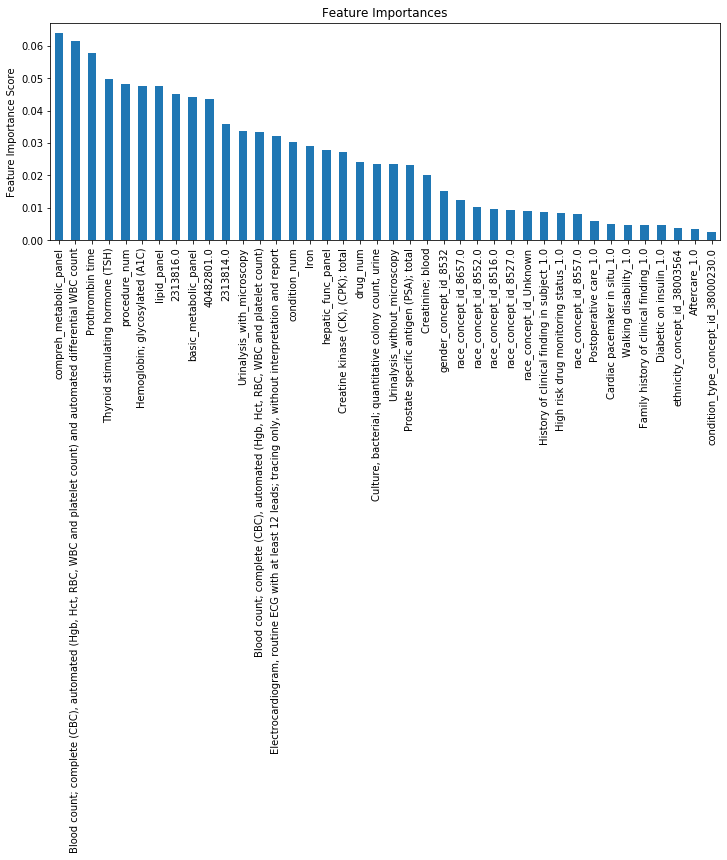

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 123)
modelfit(rf, pd.concat([X_train, y_train], axis=1), X_train.columns)

In [0]:
y_predict = rf.predict(X_test)

In [24]:
accuracy_score(y_test, y_predict)

0.9900975318471338

In [25]:
confusion_matrix(y_test, y_train)

ValueError: ignored

## Try Deep Learning